In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-gvxmie7p
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-gvxmie7p
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1086170 sha256=6ae7f3735745c2fe5f4feee9a15239776dea34e59131ab822cbcbc1facbf51df
  Stored in directory: /tmp/pip-ephem-wheel-cache-kqt1_qls/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import os
import h5py
import fitsio
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u
import matplotlib.pyplot as plt

from bgs_sv import sv1

# Get SV1 exposures during bright time until Feb 15, 2021

In [4]:
fsky = 'sv1.bright_exps.20210217.Isky.npy'
fwave = 'sv1.bright_exps.20210217.wave.npy'
fobscond = 'sv1.bright_exps.20210217.obs_cond.hdf5'

if not np.all([os.path.isfile(_f) for _f in [fsky, fwave, fobscond]]): 
    # read in Aaron's GFA data of exposures through 2021/02/01
    gfa = atable.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_20210215.fits')['NIGHT', 'EXPID', 'AIRMASS', 'SKY_MAG_AB', 'MOON_ILLUMINATION', 'MOON_SEP_DEG', 'MOON_ZD_DEG', 'TRANSPARENCY']
    exps = gfa.group_by(['EXPID']).groups.aggregate(np.median)
    
    nominal_dark = 21.07
    bright_lim = nominal_dark - 2.5 * np.log10(2.5)

    is_bright = (exps['SKY_MAG_AB'] <= bright_lim)
    print('%i of %i exposures are during bright time' % (np.sum(is_bright), len(exps)))
    bright_exps = exps[is_bright]
    
    # get sky surface brightnesses
    Iskies = []
    for i in np.arange(len(bright_exps)):
        wave, Isky = sv1.get_obs_sky(int(bright_exps[i]['NIGHT']), int(bright_exps[i]['EXPID']), 'model', redux="daily");
        Iskies.append(Isky * 1e17)

    # only keep exposures where we have sky data
    Iskies = np.array(Iskies)

    has_sky = (np.sum(np.array(Iskies), axis=1) > 0.)

    bright_exps = bright_exps[has_sky]
    Iskies = Iskies[has_sky,:]

    # save observing conditions and sky fluxes to file
    bright_exps.write(fobscond, format='hdf5')
    np.save(fsky, Iskies)
    np.save(fwave, wave)
else: 
    bright_exps = atable.Table.read(fobscond, format='hdf5')
    Iskies = np.load(fsky)
    wave = np.load(fwave)
    
# observing conditions from median value of the GFAs
airmass = bright_exps['AIRMASS']
moon_frac = bright_exps['MOON_ILLUMINATION']
moon_sep = bright_exps['MOON_SEP_DEG']
moon_alt = 90. - bright_exps['MOON_ZD_DEG']
transp = bright_exps['TRANSPARENCY']

[]

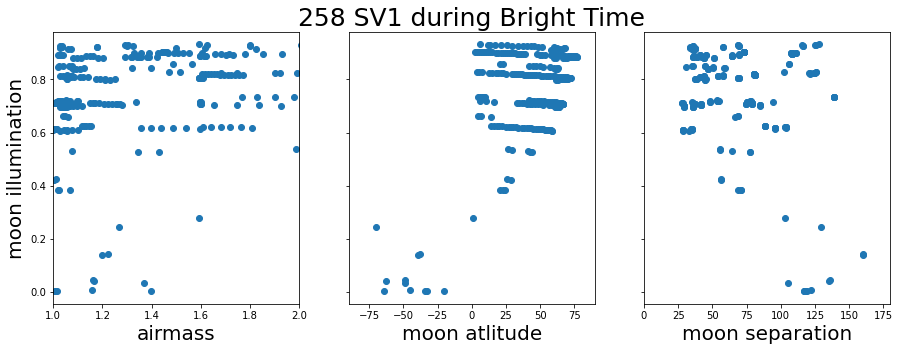

In [5]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass, moon_frac, c='C0')
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_frac, c='C0')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])
sub.set_title('%i SV1 during Bright Time' % len(bright_exps), fontsize=25)

sub = fig.add_subplot(133)
sub.scatter(moon_sep, moon_frac, c='C0')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

# get BOSS and CMX skies

In [6]:
dir_cmx = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'
dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    #fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.cmx.v1.hdf5'), 'r')
    
    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
    
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['date', 'tileid', 'expid', 
              'airmass', 'moon_ill', 'moon_alt', 'moon_sep', 
              'sun_alt', 'sun_sep', 'exptime', 'transparency']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['date'][_i] = sky_data['date'][_i_uniq]
        sky_uniq_exps['tileid'][_i] = sky_data['tileid'][_i_uniq]
        sky_uniq_exps['expid'][_i] = sky_data['expid'][_i_uniq]
        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['transparency'][_i] = np.median(sky_data['transparency'][_is_exp])

        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]

        sky_uniq_exps['sun_alt'][_i] = np.median(sky_data['sun_alt'][_is_exp])
        sky_uniq_exps['sun_sep'][_i] = np.median(sky_data['sun_sep'][_is_exp])        
        #sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0)

        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_sb_b'][_is_exp], axis=0) 
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_sb_r'][_is_exp], axis=0) 
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_sb_z'][_is_exp], axis=0)

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    boss_fiber_area = np.pi

    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [7]:
_cmx_skies = read_cmx_skies()

# apply transparency cut 
transp_cut = (_cmx_skies['transparency'] > 0.9)

cmx_skies = {} 
for k in _cmx_skies.keys():
    if k not in ['wave_b', 'wave_r', 'wave_z']: 
        cmx_skies[k] = _cmx_skies[k][transp_cut]
    else: 
        cmx_skies[k] = _cmx_skies[k]

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.692321
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.557860
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.423687
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.292890
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.162246
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.026271
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.209427
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.061903
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.944160
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.827312
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.710167
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.593746
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.477009
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [8]:
boss_skies = read_BOSS_skies()

# remove twilight
twilight = boss_skies['sun_alt'] > -15.
print('%i of %i are twilight' % (np.sum(twilight), len(boss_skies['sun_alt'])))

for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][~twilight]

40 of 1144 are twilight


[]

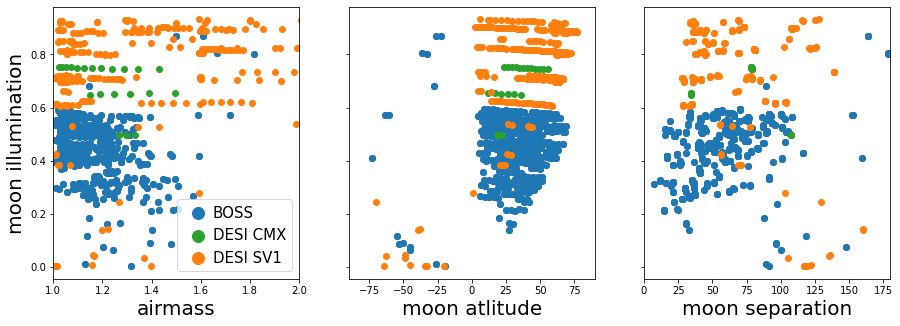

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C2', label='DESI CMX')
sub.scatter(airmass, moon_frac, c='C1', label='DESI SV1')
sub.legend(loc='lower right', frameon=True, handletextpad=0, markerscale=2, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C2')
sub.scatter(moon_alt, moon_frac, c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C2', label='DESI CMX')
sub.scatter(moon_sep, moon_frac, c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

# get sky brightness at $5000\AA$
Smooth the sky spectrum and get surface brightness at $5000A$

In [10]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing) 

In [11]:
# sky brightness at 5000A for SV1
sv1_Iskies5000 = [] 
for Isky in Iskies: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    sv1_Iskies5000.append(np.interp(5000, wave, Ismooth))
    
# sky brightness at 5000A for CMX
cmx_Iskies5000 = []
for Isky in cmx_skies['sky_b']: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    cmx_Iskies5000.append(np.interp(5000, cmx_skies['wave_b'], Ismooth))
    
# sky brightness for BOSS
boss_Iskies5000 = []
for _w, Isky in zip(boss_skies['wave_b'], boss_skies['sky_b']): 
    Ismooth = smooth_sky(Isky, smoothing=800) # BOSS has 8x smaller binning
    boss_Iskies5000.append(np.interp(5000, _w, Ismooth))

compile observing conditions and sky brightnesses

In [12]:
airmass_all = np.concatenate([airmass, cmx_skies['airmass'], boss_skies['airmass']])
moon_frac_all = np.concatenate([moon_frac, cmx_skies['moon_ill'], boss_skies['moon_ill']])
moon_alt_all = np.concatenate([moon_alt, cmx_skies['moon_alt'], boss_skies['moon_alt']])
moon_sep_all = np.concatenate([moon_sep, cmx_skies['moon_sep'], boss_skies['moon_sep']])

Iskies5000_all = np.concatenate([sv1_Iskies5000, cmx_Iskies5000, boss_Iskies5000])

# fit sky model
use polynomial regression to fit the sky surface brightness at $5000\AA$

In [13]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from itertools import chain, combinations_with_replacement

In [14]:
# train/test split
theta_train, theta_test, Isky_train, Isky_test = train_test_split(np.vstack([airmass_all, moon_frac_all, moon_alt_all, moon_sep_all]).T, Iskies5000_all, test_size=0.2, random_state=0)

In [15]:
regmodels_fsky, scores = [], [] 
for n_order in range(1, 8): 
    # we use Ridge instead of LinearRegression to regularize the coefficients
    regress_fsky = Pipeline([('poly', PolynomialFeatures(n_order)),
                             ('linear', Ridge(alpha=1., fit_intercept=False))]) 
    regress_fsky.fit(theta_train, Isky_train)
    regmodels_fsky.append(regress_fsky)
    
    # evaluate the model using crossvalidation
    _scores = cross_val_score(regress_fsky, theta_train, Isky_train, scoring="neg_mean_squared_error")
    #_scores = [-np.sum((Isky_train - regress_fsky.predict(theta_train))**2)]
    
    print('%i order: score=%f' % (n_order, -np.mean(_scores)))
    scores.append(-np.mean(_scores))
norder = np.argmin(scores)+1
regress_fsky = regmodels_fsky[np.argmin(scores)]

1 order: score=3.457226
2 order: score=2.973484
3 order: score=3.608497
4 order: score=3.167172
5 order: score=17.498120
6 order: score=233.628141
7 order: score=27548.483824


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.61429e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.65731e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.2891e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.93439e-20): result may not b

In [16]:
steps = regress_fsky.get_params()
skymodel_coeff = steps['linear'].coef_

In [17]:
skymodel_coeff

array([ 1.11964670e+00,  1.89072762e-01,  3.20306279e+00,  4.10688340e-02,
       -2.66073069e-02, -5.44857514e-01,  4.15680599e+00,  1.75625108e-02,
       -5.01143360e-03,  1.30579080e+00,  6.17225096e-02, -1.07765709e-01,
       -7.23089844e-04, -5.42455907e-04,  6.32035728e-04])

Lets see how well it reproduces the test sky brightnesses

In [18]:
def new_skymodel(airmass, moon_frac, moon_alt, moon_sep):
    ''' third degree polynomial regression sky model
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_alt, moon_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, norder+1))
    theta_transform = np.empty((theta.shape[0], len(skymodel_coeff)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, skymodel_coeff.T)

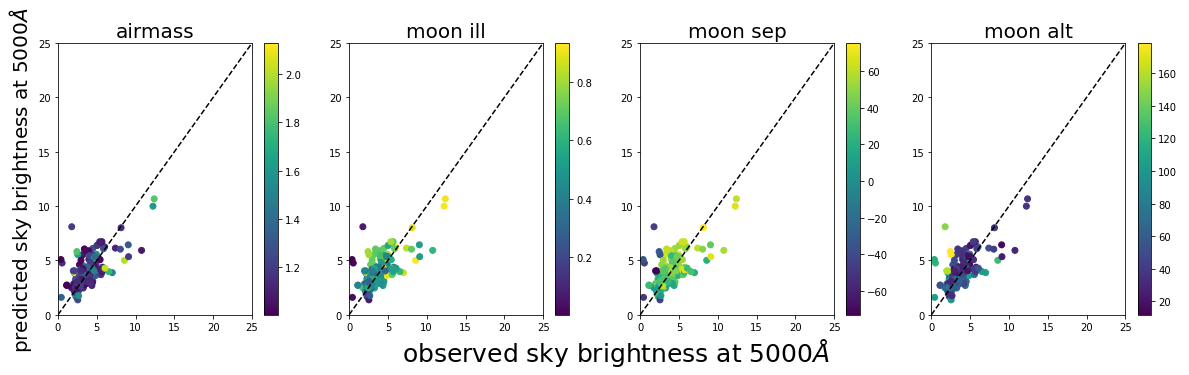

In [19]:
fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(Isky_test, new_skymodel(*theta_test.T), c=theta_test[:,i])
    sub.plot([0., 40.], [0., 40.], c='k', ls='--')
    sub.set_xlim([0., 25.])
    if i == 0: 
        sub.set_ylabel('predicted sky brightness at $5000\AA$', fontsize=20)
    sub.set_ylim([0., 25.])
    sub.set_title(k.replace('_', ' '), fontsize=20)
    fig.colorbar(_plt)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('observed sky brightness at $5000\AA$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

(0.0, 25.0)

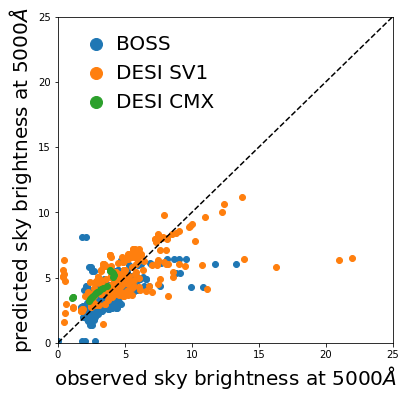

In [20]:
Iskies5000_reg = new_skymodel(*np.vstack([airmass_all, moon_frac_all, moon_alt_all, moon_sep_all]))

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.scatter(Iskies5000_all[len(airmass)+len(cmx_skies['airmass']):len(airmass)+len(cmx_skies['airmass'])+len(boss_skies['airmass'])], Iskies5000_reg[len(airmass)+len(cmx_skies['airmass']):len(airmass)+len(cmx_skies['airmass'])+len(boss_skies['airmass'])], c='C0', label='BOSS')
sub.scatter(Iskies5000_all[:len(airmass)], Iskies5000_reg[:len(airmass)], c='C1', label='DESI SV1')
sub.scatter(Iskies5000_all[len(airmass):len(airmass)+len(cmx_skies['airmass'])], Iskies5000_reg[len(airmass):len(airmass)+len(cmx_skies['airmass'])], c='C2', label='DESI CMX')

sub.plot([0., 40.], [0., 40.], c='k', ls='--')
sub.legend(loc='upper left', markerscale=2, handletextpad=0, frameon=False, fontsize=20)
sub.set_xlabel('observed sky brightness at $5000\AA$', fontsize=20) 
sub.set_xlim([0., 25.])
sub.set_ylabel('predicted sky brightness at $5000\AA$', fontsize=20)
sub.set_ylim([0., 25.])

<ipython-input-21-9ff8080036fb>:1: RuntimeWarning: divide by zero encountered in true_divide
  outliers = (Iskies5000_reg / Iskies5000_all < 0.8)
No handles with labels found to put in legend.


sky model underpredicts by >20percent for 141 of 1383 exposures


[]

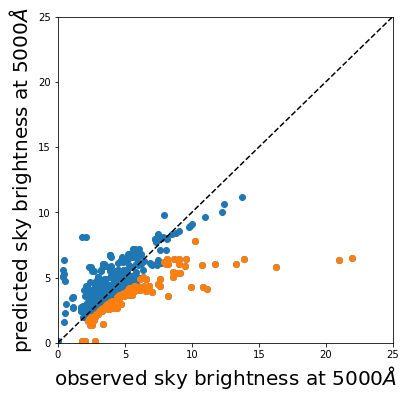

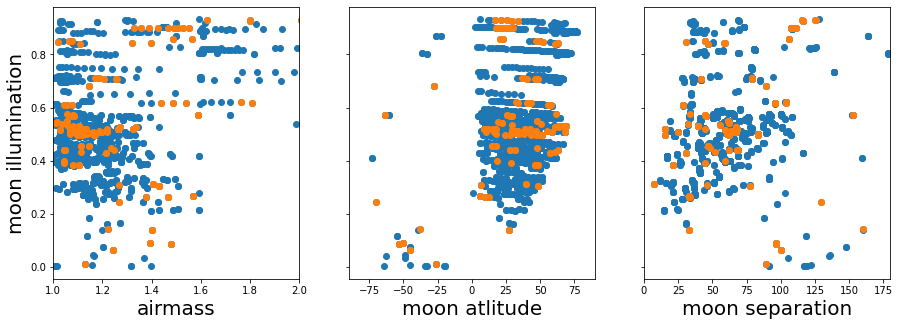

In [21]:
outliers = (Iskies5000_reg / Iskies5000_all < 0.8)
print('sky model underpredicts by >20percent for %i of %i exposures' % (np.sum(outliers), len(outliers)))

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.scatter(Iskies5000_all, Iskies5000_reg)
sub.scatter(Iskies5000_all[outliers], Iskies5000_reg[outliers])

sub.plot([0., 40.], [0., 40.], c='k', ls='--')
sub.legend(loc='upper left', markerscale=2, handletextpad=0, frameon=False, fontsize=20)
sub.set_xlabel('observed sky brightness at $5000\AA$', fontsize=20) 
sub.set_xlim([0., 25.])
sub.set_ylabel('predicted sky brightness at $5000\AA$', fontsize=20)
sub.set_ylim([0., 25.])


fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass_all, moon_frac_all, c='C0')
sub.scatter(airmass_all[outliers], moon_frac_all[outliers], c='C1')
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt_all, moon_frac_all, c='C0')
sub.scatter(moon_alt_all[outliers], moon_frac_all[outliers], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(moon_sep_all, moon_frac_all, c='C0')
sub.scatter(moon_sep_all[outliers], moon_frac_all[outliers], c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])